In [10]:
from dqn_model import DQN, Transition, ReplayBuffer

import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

import gym
env = gym.make("Wordle-v0")

# set up matplotlib
is_ipython = "inline" in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)

In [11]:
import sys, inspect
import gym_wordle
import gym_wordle.wordle as gw

print("python:", sys.executable)
print("gym_wordle package:", gym_wordle.__file__)
print("wordle module:", gw.__file__)

# Confirm loaded step source
print(inspect.getsource(gw.WordleEnv.step))

python: /Users/ethanhersch/anaconda3/envs/wordle-env/bin/python
gym_wordle package: /Users/ethanhersch/anaconda3/envs/wordle-env/lib/python3.9/site-packages/gym_wordle/__init__.py
wordle module: /Users/ethanhersch/anaconda3/envs/wordle-env/lib/python3.9/site-packages/gym_wordle/wordle.py
    def step(self, action):
        """Run one step of the Wordle game. Every game must be previously
        initialized by a call to the `reset` method.

        Args:
            action: Word guessed by the agent.
        Returns:
            state (object): Wordle game state after the guess.
            reward (float): Reward associated with the guess (-1 for incorrect,
              0 for correct)
            done (bool): Whether the game has ended (by a correct guess or
              after six guesses).
            info (dict): Auxiliary diagnostic information (empty).
        """
        assert self.action_space.contains(action), "Invalid word!"

        # transform the action, solution indices 

In [12]:
import sys, gym_wordle, gym_wordle.wordle as gw
print(sys.executable)
print(gym_wordle.__file__)
print(gw.__file__)

/Users/ethanhersch/anaconda3/envs/wordle-env/bin/python
/Users/ethanhersch/anaconda3/envs/wordle-env/lib/python3.9/site-packages/gym_wordle/__init__.py
/Users/ethanhersch/anaconda3/envs/wordle-env/lib/python3.9/site-packages/gym_wordle/wordle.py


In [13]:
import gym_wordle.wordle as gw
import inspect

print("loaded module path:", gw.__file__)
print("source file for step:", inspect.getsourcefile(gw.WordleEnv.step))

# Read file contents directly from disk (bypasses import cache)
with open(gw.__file__, "r") as f:
    txt = f.read()

print("Has my new reward code?", "n_green" in txt or "0.25 * n_green" in txt)
print(txt[txt.find("def step"): txt.find("def step")+1200])

loaded module path: /Users/ethanhersch/anaconda3/envs/wordle-env/lib/python3.9/site-packages/gym_wordle/wordle.py
source file for step: /Users/ethanhersch/anaconda3/envs/wordle-env/lib/python3.9/site-packages/gym_wordle/wordle.py
Has my new reward code? True
def step(self, action):
        """Run one step of the Wordle game. Every game must be previously
        initialized by a call to the `reset` method.

        Args:
            action: Word guessed by the agent.
        Returns:
            state (object): Wordle game state after the guess.
            reward (float): Reward associated with the guess (-1 for incorrect,
              0 for correct)
            done (bool): Whether the game has ended (by a correct guess or
              after six guesses).
            info (dict): Auxiliary diagnostic information (empty).
        """
        assert self.action_space.contains(action), "Invalid word!"

        # transform the action, solution indices to their words
        action = se

In [ ]:
# Shows updated reward function
obs = env.reset()
for _ in range(5):
    obs, r, done, info = env.step(env.action_space.sample())  # gym_wordle API
    print("reward:", r)
    if done:
        break

reward: 0.15000000000000002
reward: 0.05
reward: 0.2
reward: 0.2
reward: -0.05


In [15]:
obs = env.reset()
print("reset returned:", type(obs), obs)

# Gymnasium often returns (obs, info)
if isinstance(obs, tuple) and len(obs) == 2:
    obs, info = obs

print("obs type:", type(obs))
try:
    print("obs shape:", np.array(obs).shape)
except Exception as e:
    print("cannot shape obs:", e)

print("observation_space:", env.observation_space)
print("action_space:", env.action_space)

reset returned: <class 'numpy.ndarray'> [[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
obs type: <class 'numpy.ndarray'>
obs shape: (6, 10)
observation_space: Box([[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]], [[26 26 26 26 26  4  4  4  4  4]
 [26 26 26 26 26  4  4  4  4  4]
 [26 26 26 26 26  4  4  4  4  4]
 [26 26 26 26 26  4  4  4  4  4]
 [26 26 26 26 26  4  4  4  4  4]
 [26 26 26 26 26  4  4  4  4  4]], (6, 10), int64)
action_space: Discrete(12972)


In [16]:
import importlib, dqn_model
importlib.reload(dqn_model)
from dqn_model import DQN


In [17]:
t = env.reset()
t

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [18]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer

BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.01
EPS_DECAY = 2500
TAU = 0.005
LR = 3e-4


# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
# state, info = env.reset()
state = env.reset()
#state = np.reshape(state, 60)
n_observations = 60

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayBuffer(10000)


steps_done = 0

In [19]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(
        -1.0 * steps_done / EPS_DECAY
    )
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor(
            [[env.action_space.sample()]], device=device, dtype=torch.long
        )


episode_durations = []

In [20]:
def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title("Result")
    else:
        plt.clf()
        plt.title("Training...")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [21]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(
        tuple(map(lambda s: s is not None, batch.next_state)),
        device=device,
        dtype=torch.bool,
    )
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = (
            target_net(non_final_next_states).max(1).values
        )
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [22]:
def plot_rewards(rewards, show_result=False):
    plt.figure(1)
    rewards_t = torch.tensor(rewards, dtype=torch.float)
    
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.plot(rewards_t.numpy())
    # Take 100 episode averages and plot them too

SHAPE torch.Size([1, 6, 10])
-0.05
-0.05
0.05
-0.05
-0.05
-0.8
SHAPE torch.Size([1, 6, 10])
0.3
0.15000000000000002
-0.05
0.4
0.15000000000000002
-0.95
SHAPE torch.Size([1, 6, 10])
0.05
0.15000000000000002
-0.05
-0.05
0.7999999999999999
-0.95
SHAPE torch.Size([1, 6, 10])
0.05
0.2
0.05
-0.05
0.2
-0.8
SHAPE torch.Size([1, 6, 10])
0.15000000000000002
-0.05
0.15000000000000002
0.05
0.2
-0.95
SHAPE torch.Size([1, 6, 10])
-0.05
0.05
0.05
0.05
-0.05
-1.05
SHAPE torch.Size([1, 6, 10])
0.05
0.15000000000000002
0.3
-0.05
0.15000000000000002
-1.05
SHAPE torch.Size([1, 6, 10])
0.15000000000000002
0.15000000000000002
-0.05
-0.05
-0.05
-1.05
SHAPE torch.Size([1, 6, 10])
0.15000000000000002
0.05
-0.05
0.3
0.4
-0.95
SHAPE torch.Size([1, 6, 10])
0.05
0.05
0.05
0.3
0.2
-0.55
SHAPE torch.Size([1, 6, 10])
0.2
0.5
-0.05
0.05
-0.05
-0.7
SHAPE torch.Size([1, 6, 10])
0.05
0.05
-0.05
0.05
0.05
-1.05
SHAPE torch.Size([1, 6, 10])
0.35000000000000003
0.4
0.4
0.25000000000000006
0.5499999999999999
-1.05
SHAPE torc

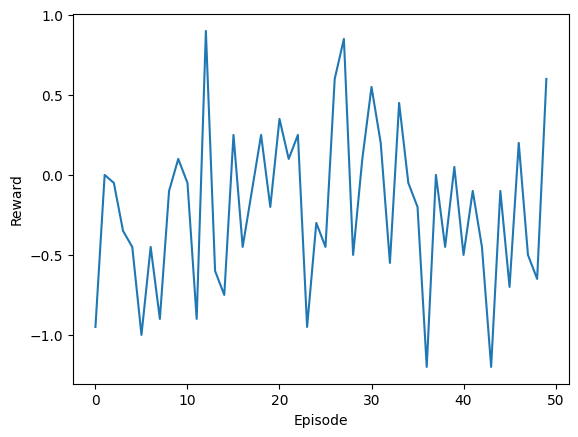

In [23]:
if torch.cuda.is_available():# or torch.backends.mps.is_available():
    num_episodes = 600
else:
    num_episodes =50

episode_returns = []

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    # state, info = env.reset()
    state = env.reset()
    #state = np.reshape(state, 60)
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    print("SHAPE", state.shape)

    ep_return = 0.0
    for t in count():
        action = select_action(state)
        # observation, reward, terminated, truncated, _ = env.step(action.item())
        observation, reward_val, terminated, truncated = env.step(action.item())
        ep_return += reward_val

        print(reward_val)

        reward = torch.tensor([reward_val], device=device)
        done = terminated or truncated

        if done:
            episode_returns.append(ep_return)  # if tracking per-episode return
            break

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(
                observation, dtype=torch.float32, device=device
            ).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[
                key
            ] * TAU + target_net_state_dict[key] * (1 - TAU)
        target_net.load_state_dict(target_net_state_dict)

plot_rewards(episode_returns)
print("Complete")
plt.show()